# IDRiD Segmentation Analysis with FiftyOne - Complete Notebook

## 🎯 Complete Analysis Pipeline

Individual cells for each step:
- ✅ Dataset creation
- ✅ Segmentation processing
- ✅ Feature extraction
- ✅ Machine Learning
- ✅ Embeddings
- ✅ **All FiftyOne Brain functions**
- ✅ FiftyOne App

Run cells in order from top to bottom.

---

## 📦 Section 1: Imports

In [18]:
# Core libraries
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("="*80)
print("IDRiD SEGMENTATION ANALYSIS WITH FIFTYONE")
print("="*80)
print(f"FiftyOne: {fo.__version__}")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)
print("\n✅ All libraries imported!\n")

IDRiD SEGMENTATION ANALYSIS WITH FIFTYONE
FiftyOne: 1.9.0
Date: 2025-10-27 18:50:48

✅ All libraries imported!



## ⚙️ Section 2: Configuration

In [19]:
# Dataset paths
BASE_PATH = Path("A. Segmentation")
IMAGES_PATH = BASE_PATH / "1. Original Images"
MASKS_PATH = BASE_PATH / "2. All Segmentation Groundtruths"

TRAIN_IMAGES_PATH = IMAGES_PATH / "a. Training Set"
TEST_IMAGES_PATH = IMAGES_PATH / "b. Testing Set"
TRAIN_MASKS_PATH = MASKS_PATH / "a. Training Set"
TEST_MASKS_PATH = MASKS_PATH / "b. Testing Set"

# Lesion types
LESION_TYPES = {
    'microaneurysms': '1. Microaneurysms',
    'haemorrhages': '2. Haemorrhages',
    'hard_exudates': '3. Hard Exudates',
    'soft_exudates': '4. Soft Exudates',
    'optic_disc': '5. Optic Disc'
}

# Dataset name
DATASET_NAME = "idrid_segmentation"

print(f"✅ Configuration loaded")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Lesion types: {len(LESION_TYPES)}")
print(f"   Base path: {BASE_PATH.absolute()}")

✅ Configuration loaded
   Dataset: idrid_segmentation
   Lesion types: 5
   Base path: /Users/asaria/Documents/IDEAS/Eye/Indian Eye diabetes/Update/A. Segmentation


## 🛠️ Section 4: Helper Functions

## 🗑️ Section 3: Cleanup (Delete Old Dataset)

In [20]:
# ============================================================================
# CLEANUP: Delete Previous Dataset and Start Fresh
# ============================================================================

print("="*80)
print("CLEANUP - REMOVING OLD DATASET")
print("="*80 + "\n")

# Check if dataset exists
if DATASET_NAME in fo.list_datasets():
    print(f"🗑️  Found existing dataset '{DATASET_NAME}'")
    print("   Deleting to ensure clean schema...")
    
    # Delete the dataset
    fo.delete_dataset(DATASET_NAME)
    print(f"✅ Deleted '{DATASET_NAME}'")
    print("   This ensures:")
    print("      • No schema conflicts")
    print("      • Fresh embeddings")
    print("      • Clean brain runs")
    print("      • Proper field types")
else:
    print(f"✅ No existing dataset found")
    print(f"   Will create fresh dataset: '{DATASET_NAME}'")

print("\n" + "="*80 + "\n")

CLEANUP - REMOVING OLD DATASET

🗑️  Found existing dataset 'idrid_segmentation'
   Deleting to ensure clean schema...
✅ Deleted 'idrid_segmentation'
   This ensures:
      • No schema conflicts
      • Fresh embeddings
      • Clean brain runs
      • Proper field types




In [21]:
def load_mask(mask_path):
    """Load a TIF mask file and convert to binary array."""
    if not Path(mask_path).exists():
        return None
    try:
        mask = Image.open(mask_path)
        mask_array = np.array(mask)
        return (mask_array > 0).astype(np.uint8) * 255 if mask_array.max() > 1 else (mask_array * 255).astype(np.uint8)
    except:
        return None

def process_all_masks(image_id, masks_base_path, lesion_types):
    """Load all 5 lesion type masks for a given image."""
    suffixes = {
        'microaneurysms': '_MA.tif',
        'haemorrhages': '_HE.tif',
        'hard_exudates': '_EX.tif',
        'soft_exudates': '_SE.tif',
        'optic_disc': '_OD.tif'
    }
    return {k: load_mask(Path(masks_base_path) / v / f"{image_id}{suffixes[k]}") 
            for k, v in lesion_types.items()}

def get_mask_statistics(masks_dict):
    """Calculate area metrics for all lesion types."""
    stats = {}
    for lesion_type, mask_array in masks_dict.items():
        if mask_array is not None:
            lesion_pixels = np.count_nonzero(mask_array)
            percentage = (lesion_pixels / mask_array.size) * 100 if mask_array.size > 0 else 0.0
            stats[lesion_type] = {
                'pixel_count': lesion_pixels,
                'percentage': percentage,
                'has_lesion': lesion_pixels > 0
            }
        else:
            stats[lesion_type] = {'pixel_count': 0, 'percentage': 0.0, 'has_lesion': False}
    return stats

def create_fiftyone_sample(image_path, masks_dict, split, image_id):
    """Create a FiftyOne sample with segmentation labels."""
    sample = fo.Sample(filepath=str(image_path))
    sample['split'] = split
    sample['image_id'] = image_id
    stats = get_mask_statistics(masks_dict)
    lesion_types_present = []
    total_lesion_area = 0.0
    
    for lesion_type, mask_array in masks_dict.items():
        if mask_array is not None and stats[lesion_type]['has_lesion']:
            sample[lesion_type] = fo.Segmentation(mask=mask_array)
            if lesion_type != 'optic_disc':
                lesion_types_present.append(lesion_type)
                total_lesion_area += stats[lesion_type]['percentage']
        sample[f"{lesion_type}_area"] = stats[lesion_type]['percentage']
    
    sample['has_lesions'] = len(lesion_types_present) > 0
    sample['lesion_types_present'] = lesion_types_present
    sample['lesion_count'] = len(lesion_types_present)
    sample['total_lesion_area'] = total_lesion_area
    return sample

def load_segmentation_dataset(images_path, masks_path, split, lesion_types):
    """Load all images and masks for a given split."""
    image_files = sorted(list(Path(images_path).glob("*.jpg")))
    samples = []
    print(f"Loading {split} set: {len(image_files)} images")
    for img_file in tqdm(image_files, desc=f"Processing {split}"):
        try:
            masks_dict = process_all_masks(img_file.stem, masks_path, lesion_types)
            samples.append(create_fiftyone_sample(img_file, masks_dict, split, img_file.stem))
        except Exception as e:
            print(f"Error {img_file.stem}: {e}")
    print(f"✓ Loaded {len(samples)} samples\n")
    return samples

print("✅ Helper functions defined")

✅ Helper functions defined


## 📦 Section 5: Dataset Creation/Loading

In [22]:
print("="*80)
print("DATASET CREATION")
print("="*80 + "\n")

# Always create fresh dataset (old one was deleted in cleanup cell)
print(f"🆕 Creating fresh dataset: '{DATASET_NAME}'...")

# Load training samples
train_samples = load_segmentation_dataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, 'train', LESION_TYPES)

# Load testing samples
test_samples = load_segmentation_dataset(TEST_IMAGES_PATH, TEST_MASKS_PATH, 'test', LESION_TYPES)

# Create dataset
dataset = fo.Dataset(DATASET_NAME)
dataset.persistent = True
dataset.add_samples(train_samples + test_samples)

print(f"✅ Dataset created: {len(dataset)} samples")
print(f"   Training: {len(dataset.match(fo.ViewField('split') == 'train'))}")
print(f"   Testing: {len(dataset.match(fo.ViewField('split') == 'test'))}")
print("\n" + "="*80 + "\n")

DATASET CREATION

🆕 Creating fresh dataset: 'idrid_segmentation'...
Loading train set: 54 images


Processing train: 100%|██████████| 54/54 [00:04<00:00, 13.07it/s]


✓ Loaded 54 samples

Loading test set: 27 images


Processing test: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]


✓ Loaded 27 samples

 100% |███████████████████| 81/81 [27.9s elapsed, 0s remaining, 2.8 samples/s]      
✅ Dataset created: 81 samples
   Training: 54
   Testing: 27




## 🧠 Section 6: Embeddings Computation

In [23]:
print("="*80)
print("EMBEDDINGS COMPUTATION")
print("="*80 + "\n")

# Check if embeddings exist
EMBEDDINGS_AVAILABLE = "embeddings" in dataset.get_field_schema()

if EMBEDDINGS_AVAILABLE:
    sample = dataset.first()
    if sample.embeddings is None:
        EMBEDDINGS_AVAILABLE = False
        print("⚠️  Embeddings field exists but is empty")

if not EMBEDDINGS_AVAILABLE:
    print("🧠 Computing embeddings...")
    print("   This may take 2-5 minutes...")
    try:
        print("   Trying CLIP model...")
        model = foz.load_zoo_model("clip-vit-base32-torch")
        dataset.compute_embeddings(model, embeddings_field="embeddings", batch_size=4)
        print("✅ CLIP embeddings computed!")
        EMBEDDINGS_AVAILABLE = True
    except Exception as e:
        print(f"⚠️  CLIP failed: {str(e)[:100]}")
        print("   Trying ResNet50 as fallback...")
        try:
            model = foz.load_zoo_model("resnet50-imagenet-torch")
            dataset.compute_embeddings(model, embeddings_field="embeddings", batch_size=4)
            print("✅ ResNet50 embeddings computed!")
            EMBEDDINGS_AVAILABLE = True
        except Exception as e2:
            print(f"❌ Embeddings failed: {str(e2)[:100]}")
            print("   Please check your PyTorch installation")
            EMBEDDINGS_AVAILABLE = False
else:
    print("✅ Embeddings already exist")

# Verify embeddings
if EMBEDDINGS_AVAILABLE:
    sample = dataset.first()
    if sample.embeddings is not None:
        print(f"   Embedding dimension: {len(sample.embeddings)}")
        print(f"   Total samples: {len(dataset)}")
    else:
        print("⚠️  Embeddings verification failed")
        EMBEDDINGS_AVAILABLE = False

print(f"\n🎯 EMBEDDINGS_AVAILABLE = {EMBEDDINGS_AVAILABLE}")
print("="*80)

EMBEDDINGS COMPUTATION

🧠 Computing embeddings...
   This may take 2-5 minutes...
   Trying CLIP model...
You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information
You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information
You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config

## 📊 Section 7: Feature Extraction

In [24]:
print("="*80)
print("FEATURE EXTRACTION")
print("="*80 + "\n")

features_list = []
for sample in tqdm(dataset, desc="Extracting features"):
    total = sample.total_lesion_area
    features = {
        'image_id': sample.image_id,
        'split': sample.split,
        'microaneurysms_area': sample.microaneurysms_area,
        'haemorrhages_area': sample.haemorrhages_area,
        'hard_exudates_area': sample.hard_exudates_area,
        'soft_exudates_area': sample.soft_exudates_area,
        'optic_disc_area': sample.optic_disc_area,
        'total_lesion_area': total,
        'lesion_count': sample.lesion_count,
        'has_microaneurysms': 1 if sample.microaneurysms_area > 0 else 0,
        'has_haemorrhages': 1 if sample.haemorrhages_area > 0 else 0,
        'has_hard_exudates': 1 if sample.hard_exudates_area > 0 else 0,
        'has_soft_exudates': 1 if sample.soft_exudates_area > 0 else 0,
        'lesion_diversity': sample.lesion_count / 4.0,
        'area_per_lesion': total / max(sample.lesion_count, 1),
        'ma_ratio': sample.microaneurysms_area / total if total > 0 else 0,
        'he_ratio': sample.haemorrhages_area / total if total > 0 else 0,
        'hex_ratio': sample.hard_exudates_area / total if total > 0 else 0,
        'sex_ratio': sample.soft_exudates_area / total if total > 0 else 0,
        'severity_score': (sample.microaneurysms_area * 0.2 + sample.haemorrhages_area * 0.3 + 
                          sample.hard_exudates_area * 0.3 + sample.soft_exudates_area * 0.2)
    }
    features_list.append(features)

features_df = pd.DataFrame(features_list)

# Create severity labels based on total_lesion_area (NOT from predictions)
def create_severity_label(row):
    """Create severity classification based on lesion area."""
    if row['total_lesion_area'] == 0:
        return 0  # Healthy
    elif row['total_lesion_area'] < 1.0:
        return 1  # Mild
    elif row['total_lesion_area'] < 3.0:
        return 2  # Moderate
    else:
        return 3  # Severe

# Apply severity labels
features_df['severity'] = features_df.apply(create_severity_label, axis=1)

# Define severity label names
severity_labels = ['Healthy', 'Mild', 'Moderate', 'Severe']

print(f"✅ Extracted {len(features_df)} samples with {len(features_df.columns)} features")
print("\n📊 Severity Distribution:")
for i, label in enumerate(severity_labels):
    count = len(features_df[features_df['severity'] == i])
    print(f"   {label}: {count} samples")
print()

FEATURE EXTRACTION



Extracting features: 100%|██████████| 81/81 [00:09<00:00,  8.17it/s]


✅ Extracted 81 samples with 21 features

📊 Severity Distribution:
   Healthy: 0 samples
   Mild: 26 samples
   Moderate: 33 samples
   Severe: 22 samples



## 🤖 Section 8: Machine Learning

In [25]:
print("="*80)
print("MACHINE LEARNING - RANDOM FOREST")
print("="*80 + "\n")

# Prepare data
feature_cols = [col for col in features_df.columns if col not in ['image_id', 'split', 'severity']]
X = features_df[feature_cols]
y = features_df['severity']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
print("🤖 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Model trained!")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1 Score: {f1:.4f}")

MACHINE LEARNING - RANDOM FOREST

🤖 Training Random Forest...
✅ Model trained!
   Accuracy: 0.9600
   F1 Score: 0.9603


## 📝 Section 9: Add Predictions to Dataset

In [26]:
print("📝 Adding predictions to dataset...")
print("   This will add 4 fields with proper types\n")

# Get predictions for all samples
X_all_scaled = scaler.transform(X)
predictions = rf_model.predict(X_all_scaled)
pred_proba = rf_model.predict_proba(X_all_scaled)

# Add predictions to dataset with proper field types
for i, sample in enumerate(dataset):
    # Store numeric version first (int)
    sample["severity_numeric"] = int(predictions[i])
    
    # Store confidence (float)
    sample["prediction_confidence"] = float(pred_proba[i].max())
    
    # Store label string
    sample["severity_label"] = severity_labels[predictions[i]]
    
    # Store as Classification object LAST (for brain functions)
    sample["predicted_severity"] = fo.Classification(
        label=severity_labels[predictions[i]],
        confidence=float(pred_proba[i].max())
    )
    
    sample.save()

print("✅ Predictions added to dataset")
print("   Fields added:")
print("      • severity_numeric (int) - for filtering")
print("      • prediction_confidence (float) - confidence score")
print("      • severity_label (string) - human readable")
print("      • predicted_severity (Classification) - for brain functions")
print()

📝 Adding predictions to dataset...
   This will add 4 fields with proper types

✅ Predictions added to dataset
   Fields added:
      • severity_numeric (int) - for filtering
      • prediction_confidence (float) - confidence score
      • severity_label (string) - human readable
      • predicted_severity (Classification) - for brain functions



## 📈 Section 10: Confusion Matrix

Classes in test set: [np.int64(1), np.int64(2), np.int64(3)]
Labels: ['Mild', 'Moderate', 'Severe']


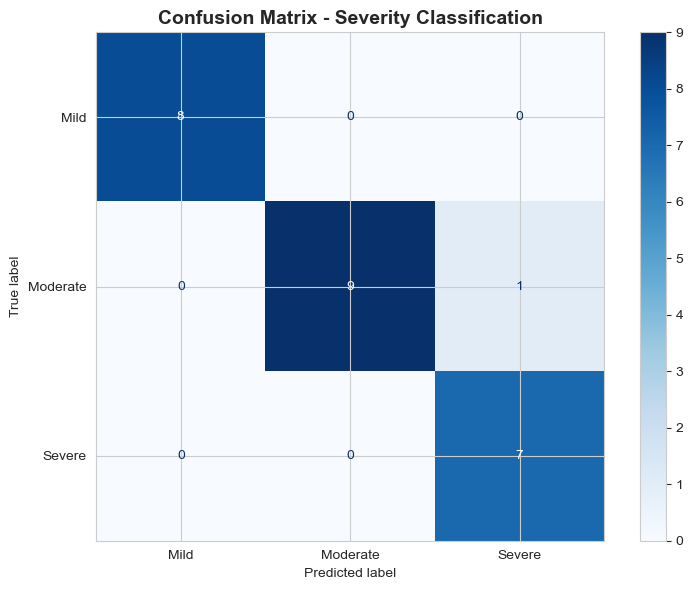


✅ Confusion matrix plotted
   Classes shown: 3


In [27]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Get unique classes in test set
unique_classes = sorted(y_test.unique())
labels_in_test = [severity_labels[i] for i in unique_classes]

print(f"Classes in test set: {unique_classes}")
print(f"Labels: {labels_in_test}")

# Create confusion matrix with only classes present in test set
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    labels=unique_classes,  # Only use classes present in test set
    display_labels=labels_in_test,  # Corresponding labels
    ax=ax, 
    cmap='Blues'
)

plt.title('Confusion Matrix - Severity Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✅ Confusion matrix plotted")
print(f"   Classes shown: {len(unique_classes)}")

## 🧠 Section 11: FiftyOne Brain Functions

In [28]:
print("="*80)
print("FIFTYONE BRAIN FUNCTIONS (LATEST API)")
print("="*80 + "\n")

if not EMBEDDINGS_AVAILABLE:
    print("⚠️  Embeddings not available. Skipping brain functions.")
    print("   Please run the embeddings cell first.")
else:
    print("✅ Embeddings available - computing brain functions...")

FIFTYONE BRAIN FUNCTIONS (LATEST API)

✅ Embeddings available - computing brain functions...


### 🔍 Brain Function 1: Similarity Search

In [29]:
if EMBEDDINGS_AVAILABLE:
    print("🔍 Computing Similarity...")
    try:
        # Check if already computed
        if "similarity" in dataset.list_brain_runs():
            print("   Similarity already computed, deleting old run...")
            dataset.delete_brain_run("similarity")
        
        # Compute similarity
        fob.compute_similarity(
            dataset,
            embeddings="embeddings",
            brain_key="similarity"
        )
        print("✅ Similarity computed")
        
        # Test similarity search
        sample = dataset.first()
        similar_view = dataset.sort_by_similarity(sample.id, k=6, brain_key="similarity")
        print(f"   Test: Found {len(similar_view)} similar images to {sample.image_id}")
        
        # Show top 3 similar
        print("   Top 3 similar images:")
        for i, s in enumerate(similar_view.skip(1).limit(3), 1):
            print(f"      {i}. {s.image_id} - Area: {s.total_lesion_area:.2f}%")
            
    except Exception as e:
        print(f"⚠️  Similarity failed: {str(e)}")
        print(f"   Error type: {type(e).__name__}")
        import traceback
        print("   Traceback:")
        traceback.print_exc()
else:
    print("⚠️  Skipping similarity - embeddings not available")

🔍 Computing Similarity...
✅ Similarity computed
   Test: Found 6 similar images to IDRiD_01
   Top 3 similar images:
      1. IDRiD_61 - Area: 10.28%
      2. IDRiD_38 - Area: 0.45%
      3. IDRiD_71 - Area: 3.05%


### 🎯 Brain Function 2: Uniqueness Detection

In [30]:
if EMBEDDINGS_AVAILABLE:
    print("\n🎯 Computing Uniqueness...")
    try:
        # Check if already computed
        if "uniqueness" in dataset.get_field_schema():
            print("   Uniqueness already computed, will overwrite...")
        
        # Compute uniqueness
        fob.compute_uniqueness(
            dataset,
            embeddings="embeddings",
            uniqueness_field="uniqueness"
        )
        print("✅ Uniqueness computed")
        
        # Show top unique samples
        unique_view = dataset.sort_by("uniqueness", reverse=True).limit(5)
        print("   Top 5 unique samples:")
        for i, s in enumerate(unique_view, 1):
            print(f"      {i}. {s.image_id} - Uniqueness: {s.uniqueness:.4f} - Lesions: {s.lesion_count}")
            
    except Exception as e:
        print(f"⚠️  Uniqueness failed: {str(e)}")
        print(f"   Error type: {type(e).__name__}")
        import traceback
        print("   Traceback:")
        traceback.print_exc()
else:
    print("⚠️  Skipping uniqueness - embeddings not available")


🎯 Computing Uniqueness...
Computing uniqueness...
Uniqueness computation complete
✅ Uniqueness computed
   Top 5 unique samples:
      1. IDRiD_75 - Uniqueness: 1.0000 - Lesions: 4
      2. IDRiD_32 - Uniqueness: 0.9933 - Lesions: 4
      3. IDRiD_81 - Uniqueness: 0.9486 - Lesions: 3
      4. IDRiD_33 - Uniqueness: 0.9480 - Lesions: 4
      5. IDRiD_43 - Uniqueness: 0.9329 - Lesions: 2


### 🎓 Brain Function 3: Hardness Computation

In [31]:
if EMBEDDINGS_AVAILABLE:
    print("\n🎓 Computing Hardness...")
    try:
        # Verify predictions are Classification objects
        sample = dataset.first()
        if not hasattr(sample, 'predicted_severity'):
            print("❌ No predictions found. Please run ML cells first.")
        elif not isinstance(sample.predicted_severity, fo.Classification):
            print(f"❌ Predictions are {type(sample.predicted_severity).__name__}, not Classification")
            print("   Please run the 'Add Predictions' cell first")
        else:
            # Check if already computed
            if "hardness" in dataset.get_field_schema():
                print("   Hardness already computed, will overwrite...")
            
            # Compute hardness
            fob.compute_hardness(
                dataset,
                label_field="predicted_severity",
                hardness_field="hardness"
            )
            print("✅ Hardness computed")
            
            # Show hardest samples
            hard_view = dataset.sort_by("hardness", reverse=True).limit(5)
            print("   Top 5 hardest samples:")
            for i, s in enumerate(hard_view, 1):
                print(f"      {i}. {s.image_id} - Hardness: {s.hardness:.4f} - Pred: {s.predicted_severity.label}")
                
    except Exception as e:
        print(f"⚠️  Hardness failed: {str(e)}")
        print(f"   Error type: {type(e).__name__}")
        import traceback
        print("   Traceback:")
        traceback.print_exc()
else:
    print("⚠️  Skipping hardness - embeddings not available")


🎓 Computing Hardness...
Computing hardness...
   0% |/------------------|  0/81 [10.2ms elapsed, ? remaining, ? samples/s] 
⚠️  Hardness failed: Sample '68ff71b9c9909e1b8169af99' field 'predicted_severity' has no logits
   Error type: ValueError
   Traceback:


Traceback (most recent call last):
  File "/var/folders/9_/n8s5994d0zg2f3q30g4x8d880000gn/T/ipykernel_23167/3672128393.py", line 17, in <module>
    fob.compute_hardness(
  File "/opt/miniconda3/envs/51eye/lib/python3.12/site-packages/fiftyone/brain/__init__.py", line 64, in compute_hardness
    return fbh.compute_hardness(samples, label_field, hardness_field, progress)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/51eye/lib/python3.12/site-packages/fiftyone/brain/internal/core/hardness.py", line 61, in compute_hardness
    hardness = brain_method.process_image(image)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/51eye/lib/python3.12/site-packages/fiftyone/brain/internal/core/hardness.py", line 111, in process_image
    label = _get_data(sample_or_frame, self.label_field)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/51eye/lib/python3.12/site-packages/f

### 📊 Brain Function 4: UMAP Visualization

In [32]:
if EMBEDDINGS_AVAILABLE:
    print("\n📊 Computing UMAP Visualization...")
    try:
        # Check if already computed
        if "umap_viz" in dataset.list_brain_runs():
            print("   UMAP already computed, deleting old run...")
            dataset.delete_brain_run("umap_viz")
        
        # Compute visualization
        print("   Computing UMAP (this may take 10-30 seconds)...")
        fob.compute_visualization(
            dataset,
            embeddings="embeddings",
            method="umap",
            brain_key="umap_viz",
            num_dims=2,
            verbose=False
        )
        print("✅ UMAP visualization computed")
        print("   View in FiftyOne App:")
        print("      1. Click 'Embeddings' button")
        print("      2. Select 'umap_viz' from dropdown")
        print("      3. Color by 'severity_label' or 'lesion_count'")
        
    except Exception as e:
        print(f"⚠️  Visualization failed: {str(e)}")
        print(f"   Error type: {type(e).__name__}")
        import traceback
        print("   Traceback:")
        traceback.print_exc()
else:
    print("⚠️  Skipping visualization - embeddings not available")


📊 Computing UMAP Visualization...
   Computing UMAP (this may take 10-30 seconds)...
Generating visualization...
✅ UMAP visualization computed
   View in FiftyOne App:
      1. Click 'Embeddings' button
      2. Select 'umap_viz' from dropdown
      3. Color by 'severity_label' or 'lesion_count'


## 📋 Section 12: Dataset Summary

In [33]:
print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80 + "\n")

print(f"📦 Dataset: {DATASET_NAME}")
print(f"   Total: {len(dataset)} samples")
print(f"   Train: {len(dataset.match(fo.ViewField('split') == 'train'))}")
print(f"   Test: {len(dataset.match(fo.ViewField('split') == 'test'))}")

print("\n🧠 Brain Functions:")
brain_runs = dataset.list_brain_runs()
if brain_runs:
    for run in brain_runs:
        print(f"   ✅ {run}")
else:
    print("   ⚠️  No brain functions computed")

print("\n🎯 Available Features:")
print("   • Segmentation masks (5 lesion types)")
print("   • Area measurements")
print("   • ML predictions & confidence")
print("   • Severity labels")
if EMBEDDINGS_AVAILABLE:
    print("   • Image embeddings")
    print("   • Similarity search")
    print("   • Uniqueness scores")
    print("   • Hardness scores")
    print("   • UMAP visualization")


DATASET SUMMARY

📦 Dataset: idrid_segmentation
   Total: 81 samples
   Train: 54
   Test: 27

🧠 Brain Functions:
   ✅ hardness
   ✅ similarity
   ✅ umap_viz
   ✅ uniqueness

🎯 Available Features:
   • Segmentation masks (5 lesion types)
   • Area measurements
   • ML predictions & confidence
   • Severity labels
   • Image embeddings
   • Similarity search
   • Uniqueness scores
   • Hardness scores
   • UMAP visualization


## 🚀 Section 13: Launch FiftyOne App

In [34]:
print("\n" + "="*80)
print("LAUNCHING FIFTYONE APP")
print("="*80 + "\n")

print("🚀 Starting FiftyOne App at http://localhost:5151\n")
print("📌 Available Features:")
print("   • View images with segmentation masks")
print("   • Filter by split, lesion type, severity")
print("   • Sort by uniqueness, hardness, confidence")
if EMBEDDINGS_AVAILABLE:
    print("   • Similarity search (click image)")
    print("   • Embeddings visualization (Embeddings panel)")

print("\n💡 Tips:")
print("   • Click 'Embeddings' button for UMAP viz")
print("   • Select sample for similarity search")
print("   • Sort by 'hardness' for difficult samples")
print("   • Sort by 'uniqueness' for outliers")

print("\n" + "="*80)
print("✅ READY TO LAUNCH")
print("="*80 + "\n")

# Launch app
session = fo.launch_app(dataset, port=5151)


LAUNCHING FIFTYONE APP

🚀 Starting FiftyOne App at http://localhost:5151

📌 Available Features:
   • View images with segmentation masks
   • Filter by split, lesion type, severity
   • Sort by uniqueness, hardness, confidence
   • Similarity search (click image)
   • Embeddings visualization (Embeddings panel)

💡 Tips:
   • Click 'Embeddings' button for UMAP viz
   • Select sample for similarity search
   • Sort by 'hardness' for difficult samples
   • Sort by 'uniqueness' for outliers

✅ READY TO LAUNCH

